In [7]:
import torch
import torchvision
from torchvision import transforms, models, datasets
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import CelebA
from torch.utils.data import Subset
import copy
from torch.utils.data import ConcatDataset

def filter_dataset(dataset, attribute_name, attribute_value):
    indices = torch.nonzero(dataset.attr[:, dataset.attr_names.index(attribute_name)] == attribute_value).squeeze()
    return torch.utils.data.Subset(dataset, indices)

# Definicja transformacji
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżka do danych CelebA
celeba_path = "C:/Users/Kacper/PycharmProjects/DeepLearning"  # Zmień na odpowiednią ścieżkę

# # Ładowanie datasetu CelebA
# celeba = CelebA(root=celeba_path, split='train', target_type="attr", transform=transform, download=True)

train_dataset = datasets.CelebA(root=celeba_path,
                                split='train',
                                target_type=['attr'] ,
                                transform=transform,
                                download=True)

val_dataset = datasets.CelebA(root=celeba_path,
                              split='valid',
                                target_type=['attr'] ,
                              transform=transform,
                              download=True)

test_dataset = datasets.CelebA(root=celeba_path,
                              split='test',
                                target_type=['attr'] ,
                               transform=transform,
                              download=True)

celeba_glasses_dataset = filter_dataset(train_dataset, 'Eyeglasses', 1)
dataset = celeba_glasses_dataset
for i in range(15):
  dataset = ConcatDataset([dataset, celeba_glasses_dataset])
test_dataset = ConcatDataset([dataset, test_dataset])


# Zidentyfikuj indeks atrybutu "Eyeglasses"
eyeglasses_index = 15

def get_binary_labels(labels, indices):
    # Wybiera tylko etykiety dla określonych indeksów i zmienia kształt tensora
    binary_labels = labels[:, indices]
    return binary_labels.float()  # Konwersja na float dla BCEWithLogitsLoss

# Przygotowanie danych do treningu i walidacji
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Definicja modelu
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # 2 atrybuty do przewidywania

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Funkcja straty i optymalizator
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Funkcja treningu
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    avg_train_losses = []
    avg_valid_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Faza treningu
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = get_binary_labels(labels, [eyeglasses_index])
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        avg_train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f}')

        # Faza walidacji
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = get_binary_labels(labels, [eyeglasses_index])
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders['val'].dataset)
        avg_valid_losses.append(epoch_loss)
        print(f'Validation Loss: {epoch_loss:.4f}')

        # deep copy the model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, avg_train_losses, avg_valid_losses


# Trening modelu
model, train_losses, valid_losses = train_model(model, criterion, optimizer, num_epochs=25)

# torch.save(model.state_dict(), 'model_attributes.pth')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/24
----------
Train Loss: 0.0255
Validation Loss: 0.0148
Epoch 1/24
----------
Train Loss: 0.0117
Validation Loss: 0.0141
Epoch 2/24
----------
Train Loss: 0.0090
Validation Loss: 0.0143
Epoch 3/24
----------
Train Loss: 0.0068
Validation Loss: 0.0150
Epoch 4/24
----------
Train Loss: 0.0048
Validation Loss: 0.0159
Epoch 5/24
----------
Train Loss: 0.0031
Validation Loss: 0.0180
Epoch 6/24
----------
Train Loss: 0.0019
Validation Loss: 0.0197
Epoch 7/24
----------
Train Loss: 0.0012
Validation Loss: 0.0216
Epoch 8/24
----------
Train Loss: 0.0008
Validation Loss: 0.0220
Epoch 9/24
----------
Train Loss: 0.0005
Validation Loss: 0.0232
Epoch 10/24
----------
Train Loss: 0.0004
Validation Loss: 0.0234
Epoch 11/24
----------
Train Loss: 0.0003
Validation Loss: 0.0249
Epoch 12/24
----------
Train Loss: 0.0002
Validation Loss: 0.0262
Epoch 13/24
----------
Train Loss: 0.0

In [9]:
torch.save(model.state_dict(), 'model_attributes.pth')

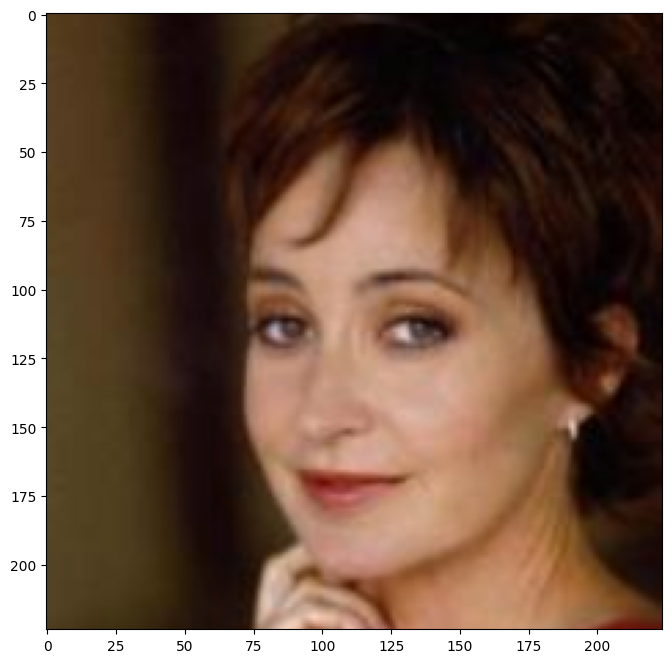

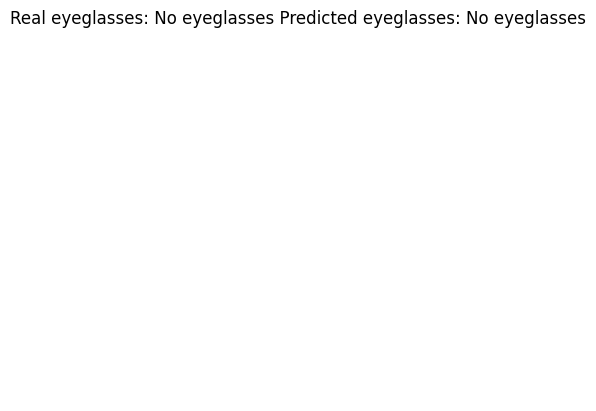

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ustawienia średniej i odchylenia standardowego dla odwrócenia normalizacji
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.squeeze().numpy().transpose((1, 2, 0))  # Dodano .squeeze() tutaj
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Pobranie jednego losowego obrazu i etykiet z DataLoadera walidacyjnego
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)

# Wybór jednego obrazu i jego etykiet
idx = np.random.randint(0, images.size(0))  # Losowy indeks w batchu
img = images[idx]
label = labels[idx]


eyeglasses_index = 15


real_eyeglasses = None
if label[eyeglasses_index] == 1:
    real_eyeglasses = "Eyeglasses"
else:
     real_eyeglasses = "No eyeglasses"

# Przetwarzanie pojedynczego obrazu przez model
model.eval()
with torch.no_grad():
    img = img.to(device).unsqueeze(0)  # Dodajemy wymiar batchu
    output = model(img)
    pred = torch.sigmoid(output).round()  # wyniki są prawdopodobieństwami

pred = pred.cpu().numpy().flatten()

pred_eyeglasses = None
if pred[0] > 0.5:
    pred_eyeglasses = "Eyeglasses"
else:
    pred_eyeglasses = "No eyeglasses"




# # Przygotowanie etykiet do wyświetlenia
# predicted_labels = ', '.join(predicted_attrs)
# actual_labels = [attr_names[i] for i, actual in enumerate(label.cpu().numpy()) if actual == 1 and i in [male_index, eyeglasses_index]]


# Wyświetlanie obrazu z predykcjami i etykietami rzeczywistymi
plt.figure(figsize=(8, 8))
imshow(img.cpu().data)  # Teraz funkcja imshow poradzi sobie z obrazem
plt.axis('off')
plt.title(f"Real eyeglasses: {real_eyeglasses} Predicted eyeglasses: {pred_eyeglasses}")
plt.show()

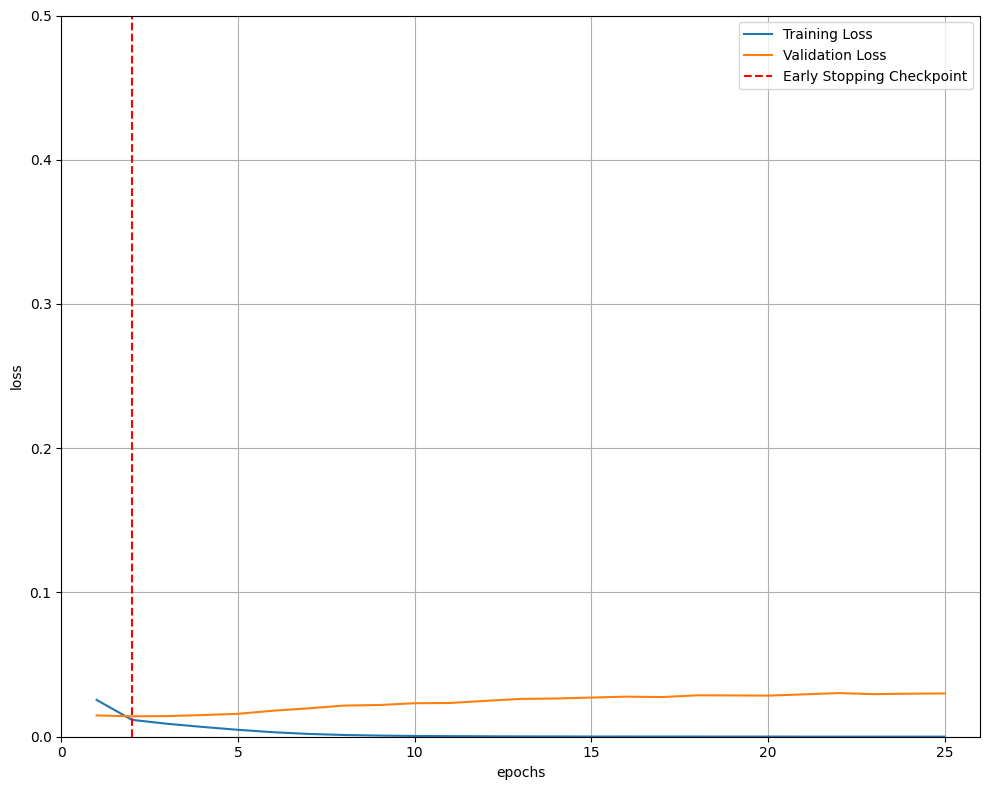

In [11]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1),valid_losses,label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)
plt.xlim(0, len(train_losses)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')